<a href="https://colab.research.google.com/github/kelseylieberman/Random_Assignments/blob/master/Route_Finding_and_Bayesian_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Route Finding and Bayesian Networks

A Project by **Kelsey Lieberman**

---


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors

---
## [50 pts] Problem 1:  Route-finding

Consider the map of the area to the west of the Engineering Center given below, with a fairly coarse Cartesian grid superimposed.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/engineering_center_grid_zoom.png" style="width: 800px;"/>

The green square at $(x,y)=(1,15)$ is the starting location, and you would like to walk from there to the yellow square at $(25,9)$ with the **shortest total path length**. The filled-in blue squares are obstacles, and you cannot walk through those locations.  You also cannot walk outside of this grid.

Legal moves in the North/South/East/West directions have a step cost of 1. Moves in the diagonal direction (for example, from $(1,15)$ to $(2,14)$) are allowed, but they have a step cost of $\sqrt{2}$. 

Of course, you can probably do this problem (and likely have to some degree, in your head) without a search algorithm. But that will hopefully provide a useful "sanity check" for your answer.

#### Part A
Write a function `adjacent_states(state)`:
* takes a single argument `state`, which is a tuple representing a valid state in this state space
* returns in some form the states reachable from `state` and the step costs. How exactly you do this is up to you.

Print to the screen the output for `adjacent_states((1,15))`.

In [2]:
board = {}
start = (1, 15)
goal = (25, 9)
for x in range(1, 26):
    for y in range(1, 17):
        state = (x, y)
        if(y == 1 and x >= 5 and x <= 23):
            board[state] = 'blue'
        elif(x == 1 and y >= 2 and y <= 14):
            board[state] = 'blue'
        elif(x == 2 and y >= 3 and y <= 13):
            board[state] = 'blue'
        elif(x == 3 and y >= 4 and y <= 12):
            board[state] = 'blue'
        elif(x == 4 and y >= 5 and y <= 11):
            board[state] = 'blue'
        elif(x == 10 and y >= 9 and y <= 12):
             board[state] = 'blue'
        elif(x >= 11 and x <= 13 and y >= 9 and y <= 14):
            board[state] = 'blue'
        elif(x == 14 and y >= 11 and y <= 14):
            board[state] = 'blue'
        elif(x >= 21 and x <= 25 and y >= 11 and y <= 16):
            board[state] = 'blue'
        elif(state == start):
            board[state] = 'start'
        elif(state == goal):
            board[state] = 'finish'
        else:
            board[state] = 'valid'
            
def adjacent_states(state):
    adj_costs = {}
    x = state[0]
    y = state[1]
    locs = [-1, 0, 1]
    for i in locs:
        for j in locs:
            if((x+i, y+j) in board.keys() and state != (x+i, y+j) and board[(x+i, y+j)] != 'blue'):
                if i == 0 or j == 0:
                    adj_costs[(x+i, y+j)] = 1
                else:
                    adj_costs[(x+i, y+j)] = np.sqrt(2)
    return(adj_costs)
print(adjacent_states((1, 15)))

{(1, 16): 1, (2, 14): 1.4142135623730951, (2, 15): 1, (2, 16): 1.4142135623730951}


#### Part B
Three candidate heuristic functions might be:
1. `heuristic_cols(state, goal)` = number of columns between the argument `state` and the `goal`
1. `heuristic_rows(state, goal)` = number of rows between the argument `state` and the `goal`
1. `heuristic_eucl(state, goal)` = Euclidean distance between the argument `state` and the `goal`

Write a function `heuristic_max(state, goal)` that returns the maximum of all three of these heuristic functions for a given `state` and `goal`.

In [3]:
def heuristic_cols(state, goal):
    return(abs(state[0]-goal[0]) - 1)
           
def heuristic_rows(state, goal):
    return(abs(state[1]-goal[1]) - 1)

def heuristic_eucl(state, goal):
    a = (state[0]-goal[0])**2
    b = (state[1]-goal[1])**2
    return np.sqrt(a + b)

def heuristic_max(state, goal):
    a = heuristic_cols(state, goal)
    b = heuristic_rows(state, goal)
    c = heuristic_eucl(state, goal)
    return max(a, b, c)

#### Part C
Is the Manhattan distance an admissible heuristic function for this problem?  Explain why or why not.

The Manhattan distance is not an admissible heuristic function for this problem because it overestimates the cost of going from the start to the goal in this problem. The Manhattan distance does not account for diagonal movement; a diagonal move according to the manhattan distance function will result in a cost of 2, one for a move in the x-direction and one for a move in the y-direction. This overestimates the cost of a diagonal movement in the context of this problem: $\sqrt{2}$. Since the start and the goal are not parallel, an optimal solution will require diagonal movement and so the Manhattan distance would overestimate the cost from start to goal and is therefore not an admissible heuristic.

#### Part D
Use A\* search and the `heuristic_max` heuristic to find the shortest path from the initial state at $(1,15)$ to the goal state at $(25,9)$. Your search **should not** build up the entire state space graph in memory. Instead, use the `adjacent_states` function from Part A, similarly to the 8-tile problem from Homework 3.

In [4]:
class Node:
    def __init__(self, h, parent, children, distance, state):
        self.h = h
        self.parent = parent
        self.children = children
        self.distance = distance
        self.state = state

def adj_distance(s1, s2):
    if(s1[0] == s2[0] or s1[1] == s2[1]): #same x or y coordinate then not diagonal
        return 1
    else:
        return np.sqrt(2)
        
def A_star(start, goal):
    root = Node(heuristic_max(start, goal), None, adjacent_states(start), 0, start)
    nodeCosts = {}
    for child in root.children:
        h = heuristic_max(child, goal)
        d = root.distance + adj_distance(root.state, child)
        nodeCosts[child] = (h + d, d)
    min_node = min(nodeCosts, key=nodeCosts.get)
    while( min_node != goal ):
        root_prev = root
        root = Node(heuristic_max(min_node, goal), root_prev, adjacent_states(min_node), nodeCosts[min_node][1], min_node)
        nodeCosts = {}
        for child in root.children:
            h = heuristic_max(child, goal)
            d = root.distance + adj_distance(root.state, child)
            nodeCosts[child] = (h + d, d)
        min_node = min(nodeCosts, key=nodeCosts.get)
    totalCost = nodeCosts[min_node][1]
    # now to retrace the path
    path = [root.state]
    while root.parent != None:
        root = root.parent
        path.insert(0, root.state)
    path.append(goal)
    return path, totalCost

path, totalCost = A_star(start, goal)
print(path, totalCost)

[(1, 15), (2, 15), (3, 15), (4, 15), (5, 15), (6, 15), (7, 15), (8, 15), (9, 15), (10, 15), (11, 15), (12, 15), (13, 15), (14, 15), (15, 14), (16, 13), (17, 13), (18, 12), (19, 12), (20, 11), (21, 10), (22, 10), (23, 10), (24, 10), (25, 9)] 26.485281374238575


#### Part E
Make a figure depicting the optimal route from the initial state to the goal, similarly to how you depicted the maze solution in Homework 2.

[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 3]
 [1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]]


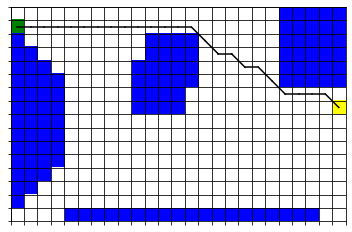

In [5]:
maze = np.zeros((16, 25), dtype=int)
for state in board.keys():
    if board[state] == 'blue':
        maze[state[1]-1][state[0]-1] += 1
    elif board[state] == 'start':
        maze[state[1]-1][state[0]-1] += 2
    elif board[state] == 'finish':
        maze[state[1]-1][state[0]-1] += 3
print(maze)

def plot_maze(maze, path=None):
    ''' visualize the binary `maze` (assumed numpy array) and solution `path` (if provided)'''

    nrow, ncol = maze.shape
    
    # create colormap
    cmap = colors.ListedColormap(['white', 'blue', 'green', 'yellow'])

    fig, ax = plt.subplots()
    ax.imshow(maze, cmap=cmap, origin='lower')
    
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k')
    ax.set_xticks(np.arange(-.5, ncol, 1))
    ax.set_yticks(np.arange(-.5, nrow, 1))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    # now draw the solution path, if one is provided
    if path:
        for p in range(len(path)-1):
            point = list(path[p])
            point[0] -= 1
            point[1] -= 1
            nextpoint = list(path[p+1])
            nextpoint[0] -= 1
            nextpoint[1] -= 1
            plt.plot([point[0],nextpoint[0]], [point[1],nextpoint[1]], c='black')
        
    plt.show()
    
plot_maze(maze, path=path)


---
## [50 pts] Problem 2:  Bayesian networks

#### Part A
In this problem, we are going to construct our own Bayesian Network. The probabilities are not given outright. You will use the data file mentioned below to determine the appropriate probability distributions for each node in the Bayes net. 

Suppose we are about to go on a run and are trying to decide how far to run. Consider the Bayesian network depicted below for this decision. The length of our run ($R$, miles) is continuous and depends on the temperature ($T$, degrees Fahrenheit), which is also a continuous variable, and whether or not it is raining ($P$), which is a discrete Boolean variable.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/running_bayesnet.png" style="width: 450px;"/>

1. Read in the data set [`data_running.csv`] from the Final Practicum Moodle folder. Read in the file as a pandas data frame.

Answer/Complete the following:
1. How many data points are there?
1. Make a histogram of the distribution of temperature, with appropriate axis labels.

In [6]:
!ls
!wget -O data_running.csv "https://docs.google.com/spreadsheets/d/e/2PACX-1vSDKscVH4k6eQGPeEc0uEbGPLGSSOSHvzuu32373rq3vQRrUqsFFjX8QnRvEpoCMINEcHK3Birw3wz6/pub?gid=1467569803&single=true&output=csv"
!ls

sample_data
--2020-06-25 23:56:55--  https://docs.google.com/spreadsheets/d/e/2PACX-1vSDKscVH4k6eQGPeEc0uEbGPLGSSOSHvzuu32373rq3vQRrUqsFFjX8QnRvEpoCMINEcHK3Birw3wz6/pub?gid=1467569803&single=true&output=csv
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.100, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-0g-7o-sheets.googleusercontent.com/pub/l5l039s6ni5uumqbsj9o11lmdc/m9qlbsbenpe54hat226seap7jg/1593129415000/112526755982951355797/*/e@2PACX-1vSDKscVH4k6eQGPeEc0uEbGPLGSSOSHvzuu32373rq3vQRrUqsFFjX8QnRvEpoCMINEcHK3Birw3wz6?gid=1467569803&single=true&output=csv [following]
--2020-06-25 23:56:56--  https://doc-0g-7o-sheets.googleusercontent.com/pub/l5l039s6ni5uumqbsj9o11lmdc/m9qlbsbenpe54hat226seap7jg/1593129415000/112526755982951355797/*/e@2PACX-1vSDKscVH4k6eQGPeEc0uEbGPLGSSOSHvzuu32373rq3vQRrUqsFFjX8QnRvEpoCMINEcHK3Birw3wz6?

200
111.19878200000001
36.63805715


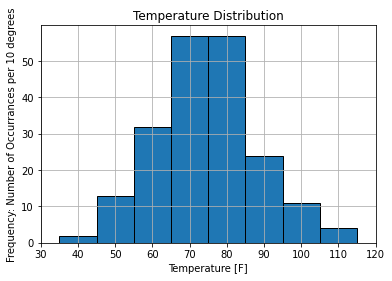

[ 2. 13. 32. 57. 57. 24. 11.  4.]

There are 200 data points


In [7]:
df = pd.read_csv('data_running.csv')
print(len(df))
df.head()
temperatures = df['temperature'].tolist()
print(max(temperatures))
print(min(temperatures))
counts, edges, plot = plt.hist(temperatures, bins=range(35, 125, 10), ec='black')
plt.grid(True)
plt.xticks(range(30, 130, 10))
plt.title('Temperature Distribution')
plt.xlabel('Temperature [F]')
plt.ylabel('Frequency: Number of Occurrances per 10 degrees')
plt.show()
print(counts)
print('\nThere are 200 data points')

#### Part B

Using the data from the file in **Part A**, decide on appropriate prior distributions for $P$ and $T$.  Note that $P$ is discrete (Boolean), while $T$ is continuous.  

Further guidance on what I am asking:

So, for the distribution of $P$, you must determine P(P=True) and P(P=False). 

For T, study the histogram from **Part A**. Does the shape of the histogram remind you of any probability distribution you've seen before? We haven't seen a continuous probability distribution in class. However, the idea is the same as a discrete probability distribution. 

Continuous dsitributions you may or may not have encountered: Exponential, Uniform, Weibull, Normal, Chi-Squared, Logistic, Student-T, F. 

Choose a continuous distribution that fits $T$ and specify the appropriate parameters.


24.0

Precipitation occurs 24% of the time according to this data so I think it is reasonable to say that P(P=True) = 0.24 and that P(P = False) = 0.76


Based on the histogram, I think a normal distribution models the temperature distribution pretty well. Most of the items in the temperature distribution are between 60 and 90 degrees. If the bin sizes are modified +- 2 degrees the data fits a normal distribution almost perfectly. Below is a depiction of the normal distribution fitted to the data, as well as a normalized histogram of the data. Seems to fit pretty well.



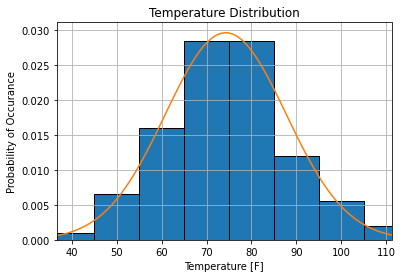

Normal distribution fitted to temperatures information:
mean = 74.292346613
standard deviation = 13.456251867899649


In [8]:
precipitation = df['rain'].tolist()
print(precipitation.count('Yes') / 2)
print('\nPrecipitation occurs 24% of the time according to this data so I think it is reasonable'
      + ' to say that P(P=True) = 0.24 and that P(P = False) = 0.76\n')
print('\nBased on the histogram, I think a normal distribution models the temperature distribution '
      + 'pretty well. Most of the items in the temperature distribution are between 60 and 90 '
      + 'degrees. If the bin sizes are modified +- 2 degrees the data fits a normal distribution '
      + 'almost perfectly. Below is a depiction of the normal distribution fitted to the data, as '
      + 'well as a normalized histogram of the data. Seems to fit pretty well.\n')
temp_min = min(temperatures)
temp_max = max(temperatures)
temp_mean = np.mean(temperatures)
temp_std = np.std(temperatures)
x = range(30, 121)
y = stats.norm.pdf(x, loc=temp_mean, scale=temp_std)
plt.hist(temperatures, bins=range(35, 125, 10), density=True, ec='black') #normed temperature histogram
plt.plot(x,y)

plt.grid(True)
plt.xlim(temp_min,temp_max)
plt.title('Temperature Distribution')
plt.xlabel('Temperature [F]')
plt.ylabel('Probability of Occurance')
plt.show()

print("Normal distribution fitted to temperatures information:")
print('mean =', temp_mean)
print('standard deviation =', temp_std)

temp_distribution = stats.norm(loc=temp_mean, scale=temp_std)
precip_distribution = {True: 0.24, False: 0.76}

#### Part C

Make two scatter plots:  one of the relationship between temperature (x-axis) and run length (y-axis) for only the days when it was raining, and one of this relationship for only the days when it was not raining. Label your axes appropriately. All of this data is contained in the csv file that you read in for **Part A**.


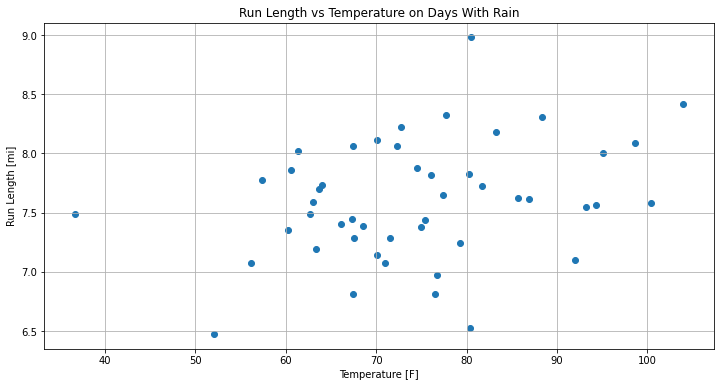

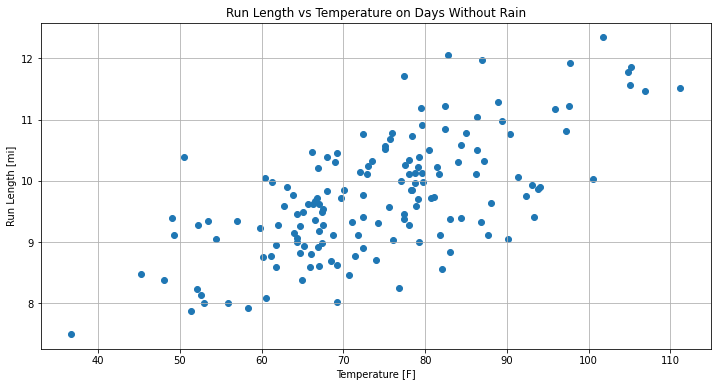

In [9]:
#filtered data
run_length_rain = df.loc[df['rain']=='Yes','length'].tolist()
run_length_noRain = df.loc[df['rain']=='No','length'].tolist()
temperature_rain = df.loc[df['rain']=='Yes','temperature'].tolist()
temperature_noRain = df.loc[df['rain']=='No','temperature'].tolist()

#plot days raining
plt.figure(figsize=(12, 6))
plt.scatter(temperature_rain, run_length_rain)
plt.title('Run Length vs Temperature on Days With Rain')
plt.xlabel('Temperature [F]')
plt.ylabel('Run Length [mi]')
plt.grid(True)
plt.show()

#plot days not raining
plt.figure(figsize=(12, 6))
plt.scatter(temperature_noRain, run_length_noRain)
plt.title('Run Length vs Temperature on Days Without Rain')
plt.xlabel('Temperature [F]')
plt.ylabel('Run Length [mi]')
plt.grid(True)
plt.show()

#### Part D:

Perform a simple linear regression on the data given the terms specified below.

Now, we need to specify the Conditional Probability table for Run length, R. Run length is necessarily non-negative, so we use a log-normal distribution as the conditional probability distribution for $R$, given $P$ and $T$. Let the log-normal parameter related to central tendency vary linearly with $T$, and categorically depending on whether or not it is raining. Keep the log-normal parameter related to distribution spread fixed. 

Lastly, we report the values of all relevant estimated parameters for the conditional probability distribution. 

Log-linear regression with no rain: intercept=1.9087, slope=0.0049
Log-linear regression with rain: intercept=1.9185, slope=0.0014
Estimate of spread, regardless of rain: 0.1396


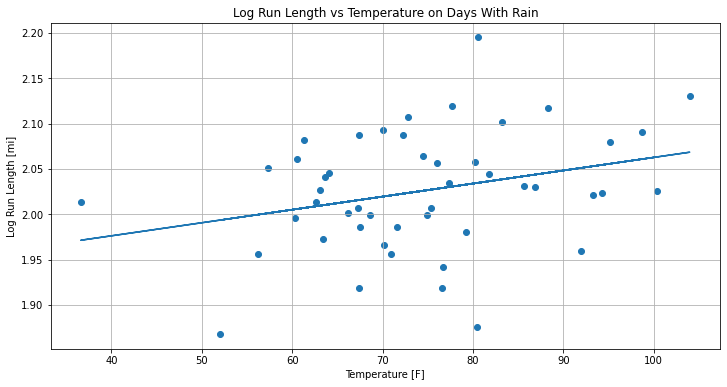

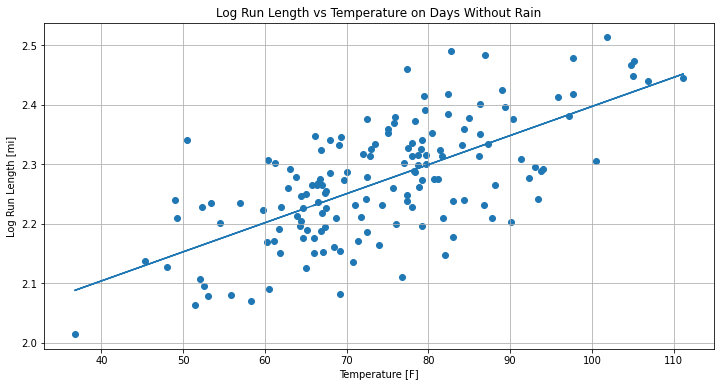

In [10]:
dfRun = df
# We are doing a simple linear regression for log(R) = alpha + beta*T, 
# where different alpha and beta are estimated for +Rain and -Rain.

lr_no = stats.linregress(dfRun.loc[dfRun['rain']=='No','temperature'], np.log(dfRun.loc[dfRun['rain']=='No','length']))
lr_yes = stats.linregress(dfRun.loc[dfRun['rain']=='Yes','temperature'], np.log(dfRun.loc[dfRun['rain']=='Yes','length']))
alpha_no, beta_no = lr_no.intercept, lr_no.slope
alpha_yes, beta_yes = lr_yes.intercept, lr_yes.slope
sigma = np.std(np.log(dfRun['length']))

# report the parameter fits
print('Log-linear regression with no rain: intercept={:0.4f}, slope={:0.4f}'.format(alpha_no, beta_no))
print('Log-linear regression with rain: intercept={:0.4f}, slope={:0.4f}'.format(alpha_yes, beta_yes))
print('Estimate of spread, regardless of rain: {:0.4f}'.format(sigma))

#plot days raining with regression line for kicks
plt.figure(figsize=(12, 6))
plt.scatter(temperature_rain, np.log(run_length_rain))
plt. plot(temperature_rain, np.add(np.multiply(beta_yes,temperature_rain), alpha_yes))
plt.title('Log Run Length vs Temperature on Days With Rain')
plt.xlabel('Temperature [F]')
plt.ylabel('Log Run Length [mi]')
plt.grid(True)
plt.show()

#plot days not raining with regression line for kicks
plt.figure(figsize=(12, 6))
plt.scatter(temperature_noRain, np.log(run_length_noRain))
plt. plot(temperature_noRain, np.add(np.multiply(beta_no,temperature_noRain), alpha_no))
plt.title('Log Run Length vs Temperature on Days Without Rain')
plt.xlabel('Temperature [F]')
plt.ylabel('Log Run Length [mi]')
plt.grid(True)
plt.show()

#### Part E

Find the following and graph your conditional probability distributions with respect to R:
- $P(R = 8 | P=T, Temp = 70)$
- $P(R = 8 | P=F, Temp = 70)$

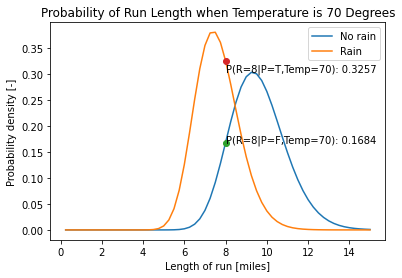

P(R=8|P=T,Temp=70) 0.3257
P(R=8|P=F,Temp=70) 0.1684


In [11]:
r = np.arange(0.25,15.25,0.25)
mu_no = alpha_no + beta_no*70 #70 degrees now instead of 80
pdf_no = [stats.lognorm.pdf(x=rx, scale=np.exp(mu_no), s=sigma) for rx in r]
mu_yes = alpha_yes + beta_yes*70 #70 degrees now instead of 80
pdf_yes = [stats.lognorm.pdf(x=rx, scale=np.exp(mu_yes), s=sigma) for rx in r]

#proabilities are just y-values at given x-coordinate
prob_no = stats.lognorm.pdf(8, scale=np.exp(mu_no), s=sigma)
prob_yes = stats.lognorm.pdf(8, scale=np.exp(mu_yes), s=sigma)

#plot proof
plt.plot(r, pdf_no, label='No rain')
plt.plot(r, pdf_yes, label='Rain')
plt.title("Probability of Run Length when Temperature is 70 Degrees")
plt.xlabel('Length of run [miles]')
plt.ylabel('Probability density [-]')
plt.annotate('P(R=8|P=F,Temp=70): ' + '{:0.4f}'.format(prob_no),(8,prob_no))
plt.annotate('P(R=8|P=T,Temp=70): ' + '{:0.4f}'.format(prob_yes),(8,prob_yes), xytext=(8, prob_yes-0.02))
plt.plot(8,prob_no, marker='o')
plt.plot(8,prob_yes, marker='o')
plt.legend()
plt.show()

prob_no = stats.lognorm.pdf(8, scale=np.exp(mu_no), s=sigma)
prob_yes = stats.lognorm.pdf(8, scale=np.exp(mu_yes), s=sigma)


print('P(R=8|P=T,Temp=70)', '{:0.4f}'.format(prob_yes))
print('P(R=8|P=F,Temp=70)', '{:0.4f}'.format(prob_no))

temp = [np.random.normal(loc=temp_mean, scale=temp_std) for x in range(10000)]

#### Part F

If you made it this far, we now have a working Bayesian Network with the CPTs specified!

Now we will get a chance to actually perform sampling from a Bayesian Network. I briefly talked about this in lecture, but I will walk you through the steps. It's a really cool way to use a Bayesian Network. Please read the comments in the code below and fill in where indicated. Specifically, look for the "# Your code here." comments.

We are going to estimate the probability of going on a run **at least** 8 miles in length. 

In [12]:
# We will be taking 10,000 random samples from our Bayesian Network.
n_iter = 10000

# The following line is specifying the threshold run length.
rlength = 8

# Select 10,000 random samples from P prior
# So that we all have the similar answers, set P(rain=True) = 0.3 and
# set P(rain=False) = 0.7
# Hint: you are sampling from a Boolean array with the specified 
# probabilities.
rain = [np.random.choice([True, False], p=[0.3, 0.7]) for x in range(n_iter)]

# Select 10,000 random samples from T prior
temp = [np.random.normal(loc=temp_mean, scale=temp_std) for x in range(n_iter)]

# sample from R | P,T conditional distribution
# Done for you.
run_length = []
for k in range(n_iter):
    mu = alpha_yes + beta_yes*temp[k] if rain[k] else alpha_no + beta_no*temp[k]
    run_length.append(stats.lognorm.rvs(scale=np.exp(mu), s=sigma))

# Create a data frame with columns for rain, temp, and length. 
# The values from the rain column should be the random samples from above.
# The values from the temp column should be the random samples above.
# The values in the length column should be the run_length values from above.

dfSample = pd.DataFrame({'rain': rain, 'temp': temp, 'length': run_length})
dfSample.head()

# Using your dfSample dataframe, compute the probability of a run
# greater than or equal to 8 miles.

#assuming probability here is based off the number of times a run is greater than or equal
#to 8 miles divided by the total number of runs. With a sample size of 10,000 this is a reasonable assumption
runs_gt_10000 = dfSample.loc[dfSample['length'] >= rlength, 'length'].tolist()
probability = len(runs_gt_10000)/len(dfSample)
print("probability of a run greater than or equal to 8 miles:", probability)
print("\nprobability of a run greater than or equal to 8 miles based on crude initial data from part A:", len(df.loc[df['length'] >= 8, 'length'].tolist())/len(df))
print('The closeness of these probabilities implies confirmation of accuracy; there is a smaller data sample in the inital data from part A, so it may be less accurate')


probability of a run greater than or equal to 8 miles: 0.7303

probability of a run greater than or equal to 8 miles based on crude initial data from part A: 0.8
The closeness of these probabilities implies confirmation of accuracy; there is a smaller data sample in the inital data from part A, so it may be less accurate
